In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import kagglehub 
import json

In [2]:
# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
img_size = 64

# Number of channels in the training images. For color images this is 3
img_channels = 3

# Size of z latent vector (i.e. size of generator input)
latent_size = 100

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
# lr = 0.0002
lr_gen = 0.00025
lr_disc = 0.00015

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

In [3]:
dataset_name = "soumikrakshit/anime-faces"
# dataset_name = "splcher/animefacedataset"
# dataset_name = "ziggykor/anime-face-dataset-expanded-2024"

formatted_dataset_name = dataset_name.replace("/","_")
path = kagglehub.dataset_download(dataset_name)

print("Path to dataset files:" , path)

Path to dataset files: /Users/yusuf/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1


In [4]:
dataset = dset.ImageFolder(root=path,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

print(f"Number of images in the dataset is {len(dataset)}")

Number of images in the dataset is 43102


In [5]:
dataset_without_transforms = dset.ImageFolder(root=path)

In [6]:
dataset[0][0].shape # each image has 3 channels and has a resolution of 64x64

torch.Size([3, 64, 64])

In [7]:
print(f"min value in dataset[0][0]: {dataset[0][0].min()}")
print(f"max value in dataset[0][0]: {dataset[0][0].max()}")

min value in dataset[0][0]: -1.0
max value in dataset[0][0]: 1.0


In [8]:
image_idx = np.random.randint(low=0, high=len(dataset), size=(4))
image_idx

array([ 4586, 16250, 37271, 13128])

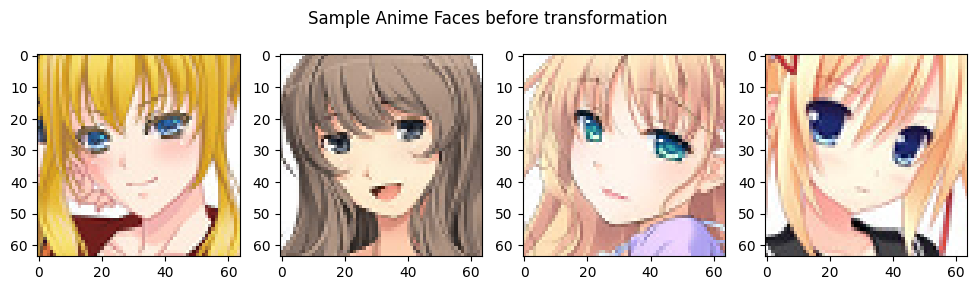

In [9]:
fix, ax = plt.subplots(ncols=4, nrows=1, figsize=(12,3))
plt.suptitle("Sample Anime Faces before transformation") 

for i in range(4):
    idx = image_idx[i]
    ax[i].imshow(dataset_without_transforms[idx][0])

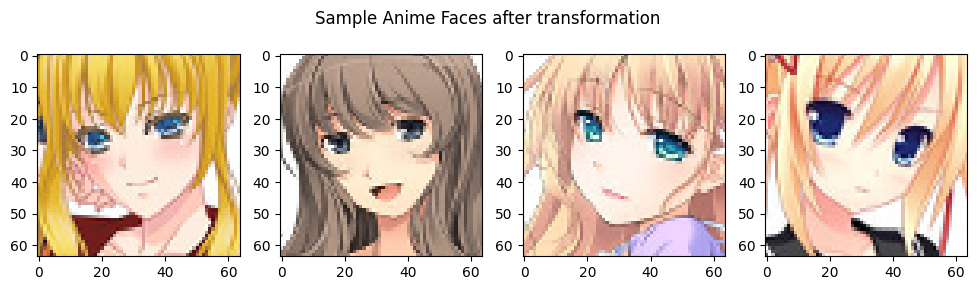

In [10]:
def denorm(img_tensors):
    return img_tensors * .5 + .5
    
fix, ax = plt.subplots(ncols=4, nrows=1, figsize=(12,3))
plt.suptitle("Sample Anime Faces after transformation")  # Adjust y-value

for i in range(4):
    idx = image_idx[i]
    ax[i].imshow(denorm(dataset[idx][0]).permute(1,2,0).detach().numpy())
plt.show()


In [11]:
# ## Select Device for Training
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

# Decide which device we want to run on
device = get_device()
print("Using device:", device)

Using device: mps


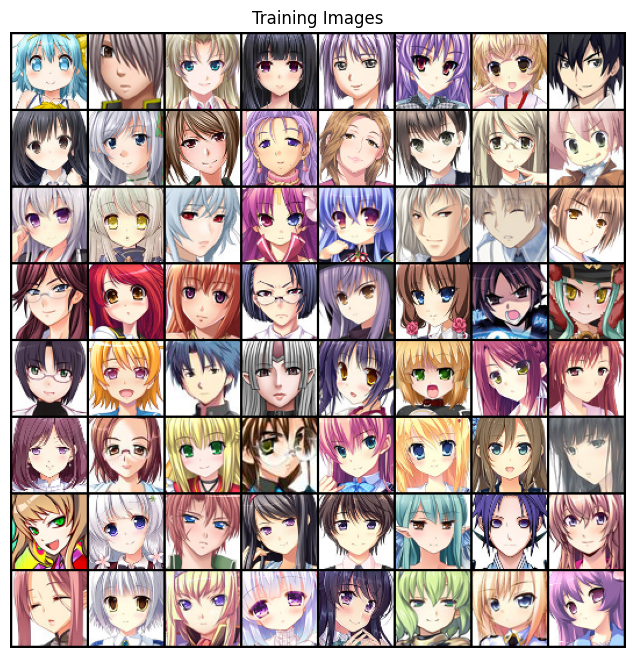

In [12]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [13]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # out: (64*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. ``(64*4) x 8 x 8``
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. ``(64*2) x 16 x 16``
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (64) x 32 x 32
            nn.ConvTranspose2d( 64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (3) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [15]:
generator = Generator().to(device)

generator.apply(weights_init)

print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # out: (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # out: (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # out: (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            # out: 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [17]:
# Create the Discriminator
discriminator = Discriminator().to(device)

discriminator.apply(weights_init)

print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [19]:
criterion = nn.BCELoss()

fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr_gen, betas=(beta1, 0.999))

In [20]:
sample_dir = f"generated_images/{formatted_dataset_name}"
os.makedirs(sample_dir, exist_ok=True)

In [21]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

def save_samples(index, latent_tensors, generator, show=True):
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    
    with torch.no_grad():
        fake = generator(latent_tensors).detach().cpu()
    
    # Convert tensor to image grid
    grid = vutils.make_grid(fake, padding=2, normalize=True).permute(1, 2, 0).numpy()
    
    # Plot and add a title
    plt.figure(figsize=(8, 8))
    plt.imshow(grid)
    plt.axis("off")  # Remove axis for a cleaner image
    plt.title(f"Epoch: {index}, Dataset: {dataset_name}")
    
    # Show the image if requested
    if show:
        plt.show()
    
    # Save the image with the title
    plt.savefig(os.path.join(sample_dir, fake_fname), bbox_inches="tight", pad_inches=0.2)
    plt.close()


In [22]:
latent_size=100
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [23]:
models_dir = f"models/{formatted_dataset_name}"
os.makedirs(models_dir, exist_ok=True)

In [24]:
def train_dcgan(num_epochs, dataloader, generator, discriminator, optimizerG, optimizerD, criterion, device,
                 real_label, fake_label, latent_size, fixed_latent):
    """
    Train a DCGAN model.
    
    Parameters:
    - num_epochs: Number of epochs to train for.
    - dataloader: Dataloader for training images.
    - generator: Generator network.
    - discriminator: Discriminator network.
    - optimizerG: Optimizer for Generator.
    - optimizerD: Optimizer for Discriminator.
    - criterion: Loss function.
    - device: Device (CPU/GPU/MPS) for training.
    - real_label: Label for real images = 1.0
    - fake_label: Label for fake images = 0.0
    - latent_size: Size of latent vector = 100
    - fixed_latent: Fixed noise vector for visualization.
    """
    # Lists to keep track of progress
    G_losses = []
    D_losses = []

    
    # Explain what Loss_D, Loss_G, D(x), D(G(z1)), and D(G(z2)) mean before training starts
    print("Explanation of Metrics:")
    print("  - Loss_D: Discriminator loss.")
    print("  - Loss_G: Generator loss.")
    print("  - D(x): Avg. Discriminator output on real images (target=1; should be high).")
    print("  - D(G(z1)): Avg. Discriminator output on fake images during Discriminator update (target=0; should be low).")
    print("  - D(G(z2)): Avg. Discriminator output on fake images during Generator update (target=1; higher means Generator is fooling Discriminator).\n")
    print("***********************")

    print("Starting Training Loop...")
    save_samples(0, fixed_latent, generator, show=False)
    
    # For each epoch
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            discriminator.zero_grad()
            real_image = data[0].to(device)
            batch_size = real_image.size(0)
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            output = discriminator(real_image).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            
            noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake = generator(noise)
            label.fill_(fake_label)
            output = discriminator(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()
            
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            generator.zero_grad()
            label.fill_(real_label)
            output = discriminator(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
            
            if i % 100 == 0:
                print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z1)): {D_G_z1:.4f} \tD(G(z2)): {D_G_z2:.4f}')
            
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
        save_samples(epoch+1, fixed_latent, generator, show=False)
        
        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({
                'generator_state_dict': generator.state_dict(),
                'epoch': epoch + 1,
            }, f'models/{formatted_dataset_name}/generator_checkpoint_epoch_{epoch+1}.pth')
            print(f'Model checkpoint saved at epoch {epoch+1}')
    
    return G_losses, D_losses

In [ ]:
G_losses, D_losses = train_dcgan(
    num_epochs=num_epochs,
    dataloader=dataloader,
    generator=generator,
    discriminator=discriminator,
    optimizerG=optimizerG,
    optimizerD=optimizerD,
    criterion=criterion,
    device=device,
    real_label=real_label,
    fake_label=fake_label,
    latent_size=latent_size,
    fixed_latent=fixed_latent,
)

Explanation of Metrics:
  - Loss_D: Discriminator loss.
  - Loss_G: Generator loss.
  - D(x): Avg. Discriminator output on real images (target=1; should be high).
  - D(G(z1)): Avg. Discriminator output on fake images during Discriminator update (target=0; should be low).
  - D(G(z2)): Avg. Discriminator output on fake images during Generator update (target=1; higher means Generator is fooling Discriminator).

***********************
Starting Training Loop...
[0/100][0/337]	Loss_D: 1.7118	Loss_G: 2.8217	D(x): 0.4216	D(G(z1)): 0.4470 	D(G(z2)): 0.0792
[0/100][100/337]	Loss_D: 1.1374	Loss_G: 5.7925	D(x): 0.7915	D(G(z1)): 0.4595 	D(G(z2)): 0.0055
[0/100][200/337]	Loss_D: 1.3510	Loss_G: 3.2648	D(x): 0.4673	D(G(z1)): 0.1614 	D(G(z2)): 0.0499
[0/100][300/337]	Loss_D: 1.0823	Loss_G: 3.5708	D(x): 0.4890	D(G(z1)): 0.0354 	D(G(z2)): 0.0407
[1/100][0/337]	Loss_D: 0.9784	Loss_G: 3.1072	D(x): 0.5554	D(G(z1)): 0.1196 	D(G(z2)): 0.0688
[1/100][100/337]	Loss_D: 1.3660	Loss_G: 6.4219	D(x): 0.8039	D(G(z

In [31]:
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerD_state_dict': optimizerD.state_dict(),
    'epoch': num_epochs,
}, f'models/{formatted_dataset_name}/model_checkpoint_latest.pth')
print(f'Latest model checkpoint saved')

# Save final loss data
loss_data = {
    "G_losses": G_losses,
    "D_losses": D_losses
}

with open(f"models/{formatted_dataset_name}/losses_final.json", "w") as f:
    json.dump(loss_data, f)

print("Final loss data saved in models/losses_final.json")

Latest model checkpoint saved
Final loss data saved in models/losses_final.json


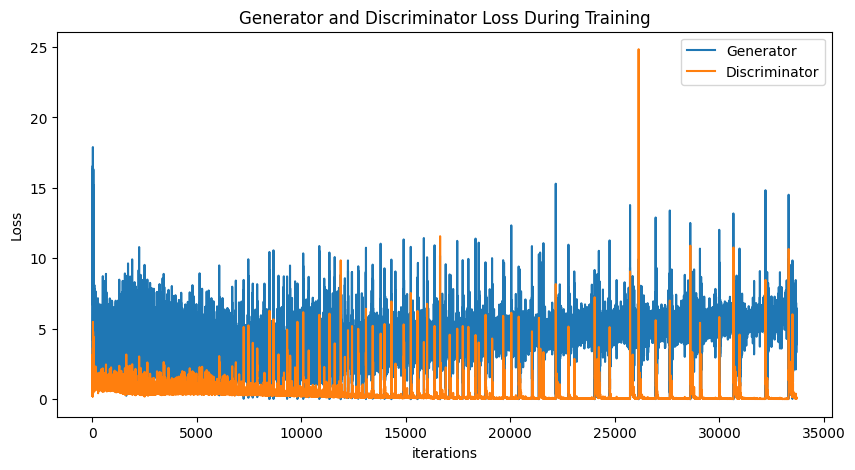

In [33]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [38]:
checkpoint = torch.load(f'models/{formatted_dataset_name}/model_checkpoint_latest.pth', map_location=device)
loaded_generator = Generator().to(device)
loaded_generator.load_state_dict(checkpoint['generator_state_dict'])
loaded_generator.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

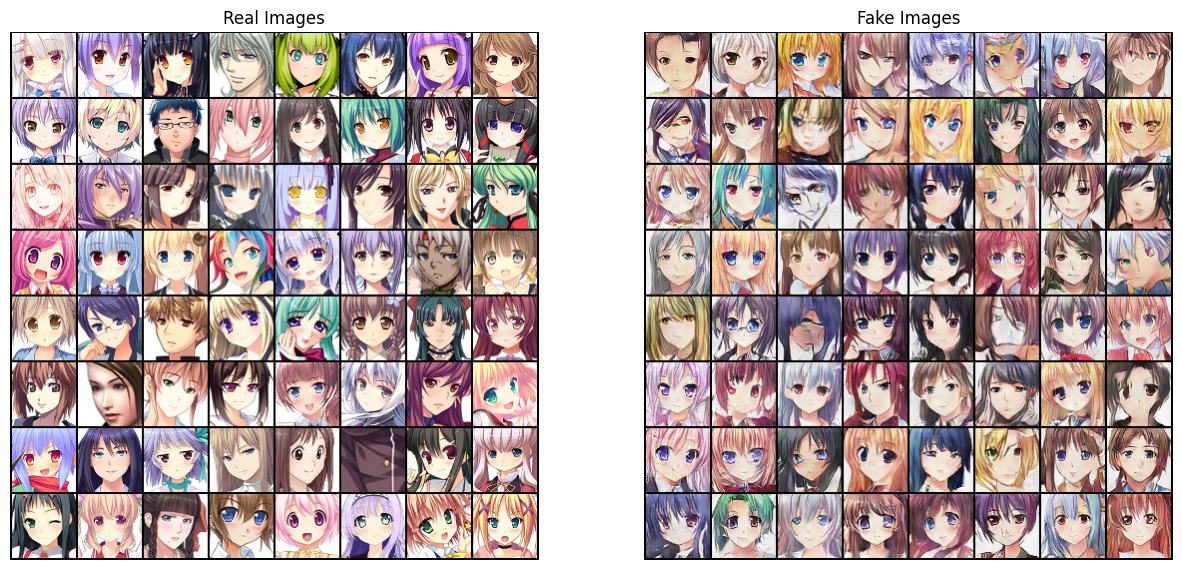

In [39]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the fake images using fixed_latent

with torch.no_grad():
    fake_images = loaded_generator(fixed_latent).detach().cpu()
# Display images
fake_img = vutils.make_grid(fake_images, padding=2, normalize=True)
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake_img,(1,2,0)))
plt.show()

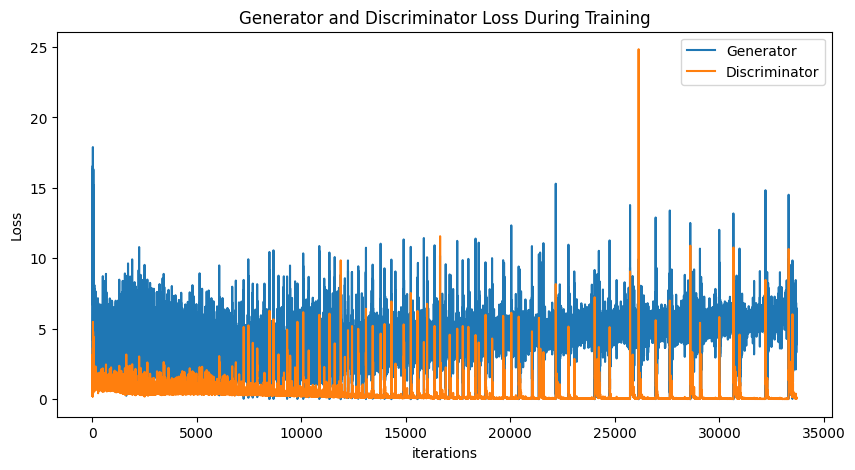

In [40]:
loss_file = f"models/{formatted_dataset_name}/losses_final.json"
with open(loss_file, "r") as f:
    loss_data = json.load(f)

G_losses = loss_data["G_losses"]
D_losses = loss_data["D_losses"]

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
checkpoint = torch.load(f'models/{formatted_dataset_name}/generator_checkpoint_epoch_{30}.pth', map_location=device)
loaded_generator = Generator().to(device)
loaded_generator.load_state_dict(checkpoint['generator_state_dict'])
loaded_generator.eval()

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the fake images using fixed_latent

with torch.no_grad():
    fake_images = loaded_generator(fixed_latent).detach().cpu()
# Display images
fake_img = vutils.make_grid(fake_images, padding=2, normalize=True)
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake_img,(1,2,0)))
plt.show()